# Double Moving Average Crossover Strategy Optimization

This notebook optimizes a `Double Moving Average Crossover` trading strategy using `Grid Search` to find the best short and long window periods for the exponential moving averages (EMAs). 

The process involves:
- Fetching historical stock data
- Generating buy and sell signals based on EMAs
- Using grid search to optimize window sizes for maximum portfolio growth
- Tracking and visualizing performance, including buy/sell transactions

The goal is to identify the most profitable moving average parameters and evaluate the strategy's performance.


## Import Libraries

In [ ]:
# Install libraries from requirements.txt file
!pip install -r requirements.txt

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
import numpy as np
from tqdm import tqdm

## Stock Data Selection
In this step, we will define the stock symbol and date range for our analysis. In this example, we are using TSLA (Tesla) as the stock symbol, but you can change this to any stock you are interested in. We will also fetch the stock data using the yfinance library.

### Select Ticker and Date Range

In [3]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date

# Prepare data for tabulation
data = [
    [stock_symbol, start_date, end_date],
]

# Display the table using tabulate
print(tabulate(data, headers=["Ticker", "Start Date", "End Date"], tablefmt="rounded_grid"))

╭──────────┬──────────────┬────────────╮
│ Ticker   │ Start Date   │ End Date   │
├──────────┼──────────────┼────────────┤
│ TSLA     │ 2024-01-01   │ 2024-12-17 │
╰──────────┴──────────────┴────────────╯


### Download Historical Data

In [4]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,240.449997,241.250000,235.300003,236.139999,85166600


### Convert Datetime

In [5]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08,236.139999,240.449997,85166600,235.300003,241.250000


### Plot Closing Price Chart

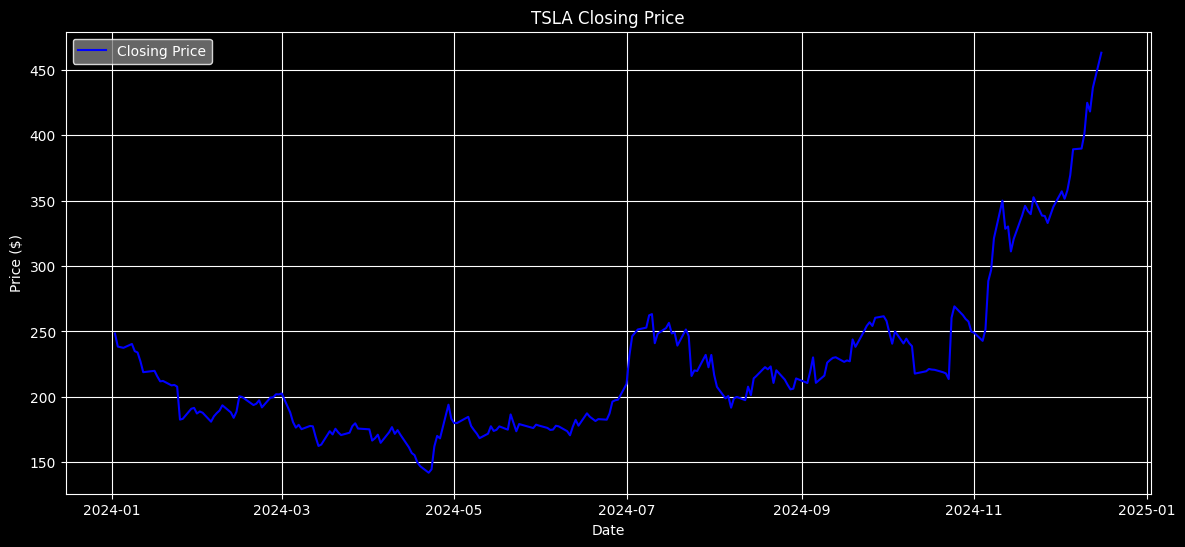

In [6]:
# Set dark mode for the plot
plt.style.use('dark_background')  # Use dark background style

# Plot the closing price
plt.figure(figsize=(14, 6))

plt.plot(df['Close'], label='Closing Price', color='blue')  # Change color for visibility

# Add title, labels, and legend with appropriate colors for dark mode
plt.title(f'{stock_symbol} Closing Price', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price ($)', color='white')
plt.legend(facecolor='gray', edgecolor='white', labelcolor='white')
plt.grid()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()


## Grid Search Optimization

### Calculate the Brokerage Fee
We define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [7]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

### Signal Generation Function

The `generate_signals` function generates buy and sell signals based on the relationship between two exponential moving averages (EMAs) — a short-term and a long-term window.

**Function Details:**
- **Input:**
    - `df (pd.DataFrame)`: DataFrame containing stock price data.
    - `short_window (int)`: The period for the short-term EMA.
    - `long_window (int)`: The period for the long-term EMA.

- **Process:**
    - Calculates the short-term and long-term EMAs of the stock's closing price.
    - Generates buy signals (`1`) when the short-term EMA crosses above the long-term EMA, and sell signals (`-1`) when the short-term EMA crosses below the long-term EMA.
    - No action (`0`) is assigned when neither condition is met.

- **Output:**
    - Returns the updated DataFrame with the generated signals and EMAs.


In [8]:
def generate_signals(df, short_window, long_window):
    # Ensure valid parameter bounds
    if short_window >= long_window:
        return np.inf  # Penalize invalid parameter combinations
        
    # Calculate EMAs
    df['SHORT_WINDOW'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['LONG_WINDOW'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Generate buy and sell signals
    df['Signal'] = np.where(
        (df['SHORT_WINDOW'] > df['LONG_WINDOW']) & (df['SHORT_WINDOW'].shift(1) <= df['LONG_WINDOW'].shift(1)), 1,  # Buy signal
        np.where(
            (df['SHORT_WINDOW'] < df['LONG_WINDOW']) & (df['SHORT_WINDOW'].shift(1) >= df['LONG_WINDOW'].shift(1)), -1,  # Sell signal
            0  # No action
        )
    )

    return df

### Investment Strategy Simulation

The `invest` function simulates a trading strategy based on buy and sell signals, records transactions, and tracks portfolio performance.

**Function Details:**
- **Input:**
    - `df (pd.DataFrame)`: DataFrame with stock data and 'Signal' column (1 for buy, -1 for sell).
    - `initial_cash (float)`: Starting cash for the portfolio.
  
- **Process:**
    - Iterates over the DataFrame, executing buy and sell actions based on signals. Updates portfolio after each transaction.
    - Adds a "no action" entry with the current price if the last action was a buy or sell.

- **Output:**
    - Returns the final portfolio value and transaction details (date, action, price, fee, portfolio value).

In [9]:
def invest(df, initial_cash):
    cash = initial_cash  # Starting cash
    shares = 0  # Starting shares
    transaction_details = []  # To store transaction records
    last_action = None  # To track the last action

    # Simulate strategy and record transactions
    for i in range(len(df)):
        date = df.index[i].date()  # Extract the date
        price = df['Close'].iloc[i]

        if df['Signal'].iloc[i] == 1 and cash > 0:  # Buy condition
            fee = calculate_fee(cash)
            shares_to_buy = (cash - fee) / price
            portfolio_value = round(shares_to_buy * price, 2)

            transaction_details.append([
                date, "BUY", round(price, 2), round(fee, 2), portfolio_value
            ])

            cash = 0  # All cash is invested
            shares += shares_to_buy
            last_action = "BUY"

        elif df['Signal'].iloc[i] == -1 and shares > 0:  # Sell condition
            value = shares * price
            fee = calculate_fee(value)
            portfolio_value = round(value - fee, 2)

            transaction_details.append([
                date, "SELL", round(price, 2), round(fee, 2), portfolio_value
            ])

            cash += value - fee  # Update cash after selling
            shares = 0  # All shares sold
            last_action = "SELL"

    # Add current date row with NO ACTION
    current_date = datetime.today().date()
    current_price = round(df['Close'].iloc[-1], 2)

    if last_action == "BUY":
        portfolio_value = round(cash + (shares * current_price), 2)
    else:  # Last action was SELL or no action
        portfolio_value = round(cash, 2)

    transaction_details.append([
        current_date, "-", current_price, "-", portfolio_value
    ])

    # Calculate final portfolio value
    final_value = portfolio_value

    return final_value, transaction_details


### Strategy Optimization

The `optimize` function performs a grid search to find the optimal short and long window parameters for the trading strategy. It evaluates each combination by running a backtest and selecting the one with the highest profit.

**Input:**
- `df (pd.DataFrame)`: Stock data with 'Close' prices.
- `initial_cash (float)`: Initial portfolio value.
- `short_window_range (range)`: Range of short window values.
- `long_window_range (range)`: Range of long window values.

**Process:**
- Iterates over all short and long window combinations.
- Generates signals, simulates trading, and calculates final portfolio value for each pair.
- Tracks the best performing parameters.

**Output:**
- Returns the best DataFrame, transaction details, and optimal short/long windows along with the highest profit.

In [10]:
def optimize(df, initial_cash, short_window_range, long_window_range):
    best_short_window = None
    best_long_window = None
    best_profit = -np.inf  # Initialize with negative infinity
    best_df = None  # Placeholder for the best DataFrame
    best_transaction_details = None

    print("Starting grid search optimization...\n")

    # Total number of iterations
    total_combinations = len(short_window_range) * len(long_window_range)
    
    # Create a progress bar
    with tqdm(total=total_combinations, desc="Optimizing", unit="iteration") as pbar:
        
        # Iterate over window combinations
        for short_window in short_window_range:
            for long_window in long_window_range:
                if short_window >= long_window:
                    continue  # Skip invalid combinations

                # Generate signals
                df_copy = df.copy()
                df_copy = generate_signals(df_copy, short_window, long_window)

                # Run backtest with invest function
                final_value, transaction_details = invest(df_copy, initial_cash)

                # Display results of current iteration
                pbar.set_postfix({f"(Short: {short_window}, Long: {long_window}), Value": f"${final_value:.2f}"})
                
                # Update best parameters if profit improves
                if final_value > best_profit:
                    best_profit = final_value
                    best_short_window = short_window
                    best_long_window = long_window
                    best_df = df_copy.copy()
                    best_transaction_details = transaction_details

                # Update the progress bar
                pbar.update(1)

    print("\nOptimization Complete!\n")

    return best_df, best_transaction_details, best_short_window, best_long_window, best_profit


### Running the Optimization

This section defines the ranges for short and long window values, initializes the portfolio, and runs the grid search optimization to find the best trading strategy.

**Process:**
- Defines short and long window ranges for optimization.
- Initializes the portfolio with a starting cash value.
- Runs the `optimize` function to determine the best short and long windows and corresponding portfolio performance.

**Output:**
- Displays the best short and long window values, along with the final portfolio value after optimization.

In [11]:
# Define the range of short and long windows to optimize
short_window_range = range(3, 11)
long_window_range = range(11, 61) 
initial_cash = 100

# Run grid search optimization
best_df, transaction_details, best_short_window, best_long_window, best_profit = optimize(df, initial_cash, short_window_range, long_window_range)

# Prepare results for tabulation
results_table = [
    ["Best Short Window", best_short_window],
    ["Best Long Window", best_long_window],
    ["Best Final Portfolio Value", f"${best_profit:.2f}"]
]

# Display optimization results using tabulate
print("\nOptimization Results:")
print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="rounded_grid"))


Starting grid search optimization...



Optimizing: 100%|██████████| 400/400 [00:04<00:00, 87.48iteration/s, (Short: 10, Long: 60), Value=$184.05]


Optimization Complete!


Optimization Results:
╭────────────────────────────┬─────────╮
│ Metric                     │ Value   │
├────────────────────────────┼─────────┤
│ Best Short Window          │ 4       │
├────────────────────────────┼─────────┤
│ Best Long Window           │ 19      │
├────────────────────────────┼─────────┤
│ Best Final Portfolio Value │ $195.98 │
╰────────────────────────────┴─────────╯


## Visualization

### Optimized Moving Averages Plot

This plot displays the closing price alongside the optimized short and long EMAs based on the best-performing parameters from the grid search.

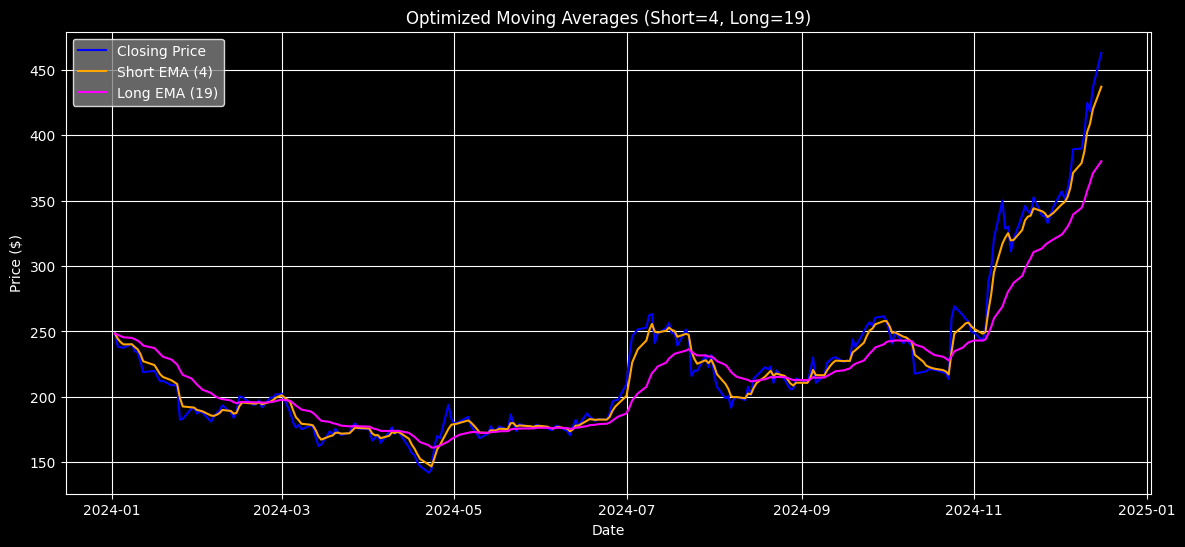

In [12]:
# Plot the closing price and moving averages from the optimized best short and long windows
plt.figure(figsize=(14, 6))

# Plot closing price
plt.plot(best_df['Close'], label='Closing Price', color='blue')

# Plot the optimized moving averages
plt.plot(best_df['SHORT_WINDOW'], label=f'Short EMA ({best_short_window})', color='orange')
plt.plot(best_df['LONG_WINDOW'], label=f'Long EMA ({best_long_window})', color='magenta')

# Add title, labels, and legend with appropriate colors for dark mode
plt.title(f"Optimized Moving Averages (Short={best_short_window}, Long={best_long_window})", color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price ($)', color='white')
plt.legend(facecolor='gray', edgecolor='white', labelcolor='white')
plt.grid()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_optimized MA_stock_chart.png', dpi=300)

# Show the plot
plt.show()


### Transaction Details and Optimization Results

This section displays the detailed transaction records, including the date, action (buy/sell), price, fee, and portfolio value.

In [13]:
# Display transaction details
print("\nTransaction Details:")
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="rounded_grid"))

# Display optimization results
print("\nOptimization Results:")
percentage_growth = ((best_profit - initial_cash) / initial_cash) * 100

results_table = [
    ["Best Short Window", best_short_window],
    ["Best Long Window", best_long_window],
    ["Initial Portfolio Value ($)", initial_cash],
    ["Final Portfolio Value ($)", round(best_profit, 2)],
    ["Total Profit/Loss ($)", round(best_profit - initial_cash, 2)],
    ["Percentage Growth (%)", f"{round(percentage_growth, 2)}%"]
]

print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="rounded_grid"))



Transaction Details:
╭────────────┬──────────┬─────────────┬───────────┬───────────────────────╮
│ Date       │ Action   │   Price ($) │ Fee ($)   │   Portfolio Value ($) │
├────────────┼──────────┼─────────────┼───────────┼───────────────────────┤
│ 2024-02-26 │ BUY      │      199.4  │ 0.25      │                 99.75 │
├────────────┼──────────┼─────────────┼───────────┼───────────────────────┤
│ 2024-03-04 │ SELL     │      188.14 │ 0.24      │                 93.88 │
├────────────┼──────────┼─────────────┼───────────┼───────────────────────┤
│ 2024-04-26 │ BUY      │      168.29 │ 0.23      │                 93.65 │
├────────────┼──────────┼─────────────┼───────────┼───────────────────────┤
│ 2024-05-13 │ SELL     │      171.89 │ 0.24      │                 95.41 │
├────────────┼──────────┼─────────────┼───────────┼───────────────────────┤
│ 2024-05-14 │ BUY      │      177.55 │ 0.24      │                 95.17 │
├────────────┼──────────┼─────────────┼───────────┼───────────────

### Plotting Transactions with Optimized Strategy

Visualization of the stock's closing price along with buy and sell signals based on the transaction details. It also overlays the optimized short and long exponential moving averages (EMAs) on the chart. Buy and sell signals are clearly marked with green and red markers, respectively, while the EMAs are plotted to reflect the optimized strategy.

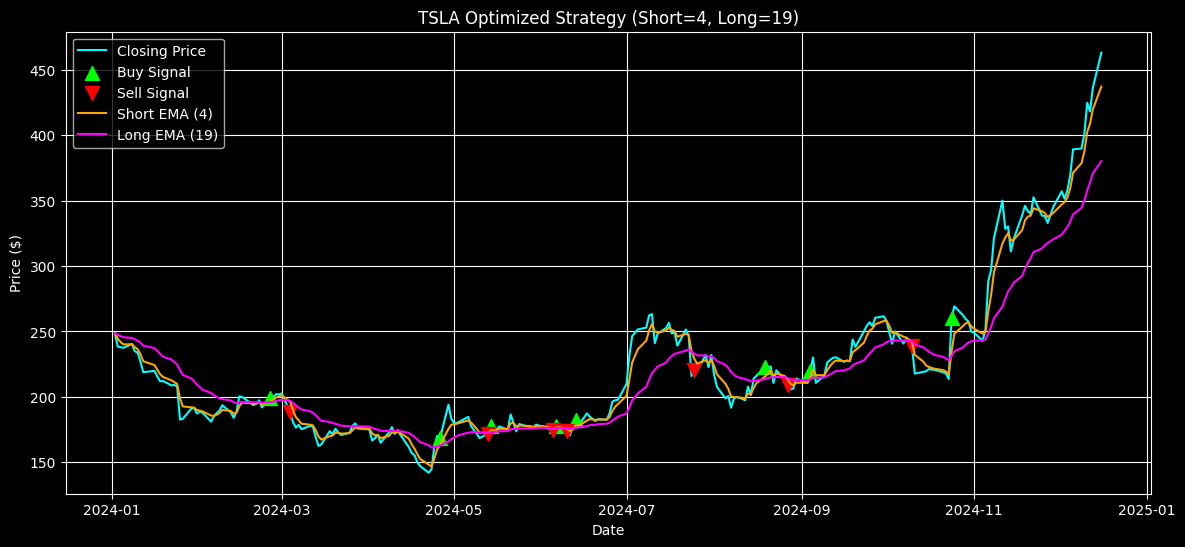

In [14]:
plt.figure(figsize=(14, 6))

# Plot closing price
plt.plot(best_df.index, best_df['Close'], label='Closing Price', color='cyan')

# Extract buy and sell signals from transaction_details
buy_dates = [row[0] for row in transaction_details if row[1] == "BUY"]
buy_prices = [row[2] for row in transaction_details if row[1] == "BUY"]

sell_dates = [row[0] for row in transaction_details if row[1] == "SELL"]
sell_prices = [row[2] for row in transaction_details if row[1] == "SELL"]

# Plot Buy and Sell signals
plt.scatter(buy_dates, buy_prices, color='lime', marker='^', s=100, label='Buy Signal', zorder=2)
plt.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell Signal', zorder=2)
    
# Plot the optimized moving averages
plt.plot(best_df['SHORT_WINDOW'], label=f'Short EMA ({best_short_window})', color='orange')
plt.plot(best_df['LONG_WINDOW'], label=f'Long EMA ({best_long_window})', color='magenta')

# Plot title and labels
plt.title(f"{stock_symbol} Optimized Strategy (Short={best_short_window}, Long={best_long_window})")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.savefig(f"{stock_symbol}_optimized_strategy_chart.png", dpi=300)
plt.show()

THANK YOU FOR READING!

For more details, insights, or to stay updated with my work, feel free to visit my [website](https://hulela.co.za/) and [Medium account](https://medium.com/@brianhulela).